
<div class="alert alert-block alert-info">
   <h2 align="center"> <center><b> Reinforcement Learning Assignment 6 - Actor Critic part 2 </b></center></h2>

<br>
<center><font size="3">This notebook is part of the teaching material for ELEC-E8125</font></center>
<center><font size="3">Sep 4, 2023 - Nov 30, 2023</font></center>
<center><font size="3">Aalto University</font></center>
</div>


<a id='TOC'></a>

<div class="alert alert-block alert-success">
    
# Table of contents
* <a href='#1.'> 1. Introduction </a>
* <a href='#1.1'> 1.1 Learning Objectives </a>
* <a href='#1.2'> 1.2 Code Structure & Files </a>
* <a href='#2.'> 2. Deep Deterministic Policy Gradient</a>
* <a href='#3.'> 3. Submitting </a>
* <a href='#3.1'> 3.1 Feedback </a>
* <a href='#8.'> References</a>

<a href='#T1'><b>Student Task 1.</b> Implement DDPG algorithm (25 points)</a>\
<a href='#Q1'><b>Student Question 1.1</b> Reasons for using off-policy data (10 points) </a>\
<a href='#Q2'><b>Student Question 2</b> Disadvantages of DDPG (10 points) </a>

    
**Total Points:** 45

# 1. Introduction <a id='1.'></a>
In this assignment, we will implement the Deep Deterministic Policy Gradient (DDPG) [1] algorithm for the **HalfCheetah-v4** environment. DDPG is a reinforcement learning algorithm that uses a critic, approximated as a neural network, to estimate values. DDPG uses policy gradient methods to update a deterministic policy (actor) to follow the critic. DDPG can be applied to problems with a continuous action space.

## 1.1 Task environments: <a id='1.1'></a>

In this exercise, we will focus on HalfCheetah-v4 tasks:
- HalfCheetah-v4(https://gymnasium.farama.org/environments/mujoco/half_cheetah/): The HalfCheetah is a 2-dimensional robot consisting of 9 body parts and 8 joints connecting them (including two paws). The goal is to apply torques on the joints to make the cheetah run forward (right) as fast as possible, with a positive reward allocated based on the distance moved forward and a negative reward allocated for moving backward. The torso and head of the cheetah are fixed, and the torque can only be applied on the other 6 joints over the front and back thighs (connecting to the torso), shins (connecting to the thighs) and feet (connecting to the shins).
<figure style="text-align: center">
    <img src="imgs/HalfCheetah-v4.png" width="300"/>
    <figcaption style="text-align: center">  Figure 1: The HalfCheetah-v4 environment. </figcaption>
</figure>

## 1.2 Learning Objectives: <a id='1.2'></a>

- Understand the DDPG algorithm
- Understand the difference between on-policy methods and off-policy methods

## 1.3 Code Structure & Files <a id='1.3'></a>

```ex6_DDPG.ipynb``` is the file needed to be modified for this part of the assignment.  

<span style="color:red"> **# IMPORTANT: DO NOT FORGET ANOTHER PART IN ```ex6_PG_AC.ipynb```** </span>

```
├───cfg                            # Config files for environments
├───imgs                           # Images used in notebook
├───results
│   └───HalfCheetah-v4
│   │   ├───logging                
│   │   │    └───logging.pkl        # Contains logged data
│   │   ├───model              
│   │   │    └───*HalfCheetah-v4_params.pt    # Contains trained model
│   │   └───video                   # Videos saved
│   │   └───*ddpg.png               # Contains training performance plot
│   └───InvertedPendulum-v4
│   │   ├───logging                
│   │   │    └───logging.pkl        # Contains logged data
│   │   ├───model              
│   │   │    └───*InvertedPendulum-v4_params.pt      # Contains trained model
│   │   └───video                   # Videos saved
│   │   └───*pg_ac.png              # Contains training performance plot
│   ex6_DDPG.ipynb                  # 2nd assignment file containing tasks <---------This task
│   ex6_PG_AC.ipynb                 # 1st assignment file containing tasks <---------
│   train.py                        # Contains train and test functions 
│   utils.py                        # Contains useful functions 
└───buffer.py                       # Contains buffer functions
```

## 1.4 Execution time <a id='1.4'></a>

The training of DDPG might take more than 30 min depending on server load. If you have problems with the training time, you can train DDPG locally.

# 2. Deep Deterministic Policy Gradient <a id='2.'></a>

<a id='T1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Task 1.</b> Implementing DDPG (25 points) </h3> 

Implement the deep deterministic policy gradient (DDPG) algorithm for the HalfCheetah environment. You can refer to the code from the "ex4_dqn.ipynb" notebook for guidance. Additionally, if necessary, consult the paper [1] for a deeper understanding of the algorithm. You can check the training performance plot in the result folder after running the plot cell.Take Figure 2 as a reference training plot. 

<figure style="text-align: center">
<img src="imgs/ddpg.png" width="400px">
<figcaption style="text-align: center"> Figure 2:  Training plot of the deterministic policy gradient on the HalfCheetah environment.
</figcaption>
</figure>

**Complete the unfinished implementation in the `DDPG` class (marked with ```TODOs```)**. 
    
1. **Agent Update Function**: Finish the `_update(self, )` function within the `DDPG` class
2. **Get Action Method**: Finish the `get_action(self, observation, evaluation=False)` function within the `DDPG` class.

**Hint:** Make always sure variables have correct dimensions!
    
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


In [5]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))
import copy, torch, yaml,time
import torch.nn.functional as F
from torch import nn
from torch.distributions import Normal
import numpy as np
from pathlib import Path
from IPython.display import Video
from buffer import ReplayBuffer
import train as t
import utils as u
device = 'cpu'

In [49]:
# Actor-critic agent

# Policy class. The policy is represented by a neural network. 
# Reminder: in DDPG the policy is deterministic.
class Policy(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super().__init__()
        self.max_action = max_action
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, action_dim)
        )

    def forward(self, state):
        return self.max_action * torch.tanh(self.actor(state))


# Critic class. The critic is represented by a neural network.
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.value = nn.Sequential(
            nn.Linear(state_dim+action_dim, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, 1))

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        return self.value(x) # output shape [batch, 1]


class DDPG(object):
    def __init__(self, state_shape, action_dim, max_action, lr, gamma, tau, batch_size, buffer_size=1e6):
        self.name = 'ddpg'
        state_dim = state_shape[0]
        self.action_dim = action_dim
        self.max_action = max_action
        self.pi = Policy(state_dim, action_dim, max_action).to(device)
        self.pi_target = copy.deepcopy(self.pi)
        self.pi_optim = torch.optim.Adam(self.pi.parameters(), lr=float(lr))

        self.q = Critic(state_dim, action_dim).to(device)
        self.q_target = copy.deepcopy(self.q)
        self.q_optim = torch.optim.Adam(self.q.parameters(), lr=float(lr))
        
        self.buffer = ReplayBuffer(state_shape, action_dim, max_size=int(float(buffer_size)))
        
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        
        # used to count number of transitions in a trajectory
        self.buffer_ptr = 0
        self.buffer_head = 0 
        self.random_transition = 5000 # collect 5k random data for better exploration
    

    def update(self,):
        """ After collecting one trajectory, update the pi and q for #transition times: """
        info = {}
        update_iter = self.buffer_ptr - self.buffer_head # update the network once per transition

        if self.buffer_ptr > self.random_transition: # update once we have enough data
            for _ in range(update_iter):
                info = self._update()
        
        # update the buffer_head:
        self.buffer_head = self.buffer_ptr
        return info


    def _update(self,):
        # get batch data
        batch = self.buffer.sample(self.batch_size, device=device)
        # batch contains:
        #    state = batch.state, shape [batch, state_dim]
        #    action = batch.action, shape [batch, action_dim]
        #    next_state = batch.next_state, shape [batch, state_dim]
        #    reward = batch.reward, shape [batch, 1]
        #    not_done = batch.not_done, shape [batch, 1]

        # TODO:
        ########## Your code starts here. ##########
        # Hints: 1. compute the Q target with the q_target and pi_target networks
        #        2. compute the critic loss and update the q's parameters
        #        3. compute actor loss and update the pi's parameters
        #        4. update the target q and pi using u.soft_update_params() (See the DQN code)
        # compute current q
        q_value = self.q.forward(batch.state, batch.action)
        
        # compute target q
        q_target = self.q_target.forward(batch.next_state, self.pi_target.forward(batch.next_state)) * batch.not_done
        
        # compute critic loss
        criterion = nn.MSELoss()
        critic_loss = criterion(q_value, batch.reward + self.gamma * q_target.detach())
        
        # optimize the critic
        self.q_optim.zero_grad()
        critic_loss.backward()
        self.q_optim.step()

        # compute actor loss
        actor_loss = - self.q.forward(batch.state, self.pi.forward(batch.state)).mean()
        
        # optimize the actor
        self.pi_optim.zero_grad()
        actor_loss.backward()
        self.pi_optim.step()

        # update the target q and target pi using u.soft_update_params() function
        u.soft_update_params(self.q, self.q_target, self.tau)
        u.soft_update_params(self.pi, self.pi_target, self.tau)
        ########## Your code ends here. ##########


        return {}

    
    @torch.no_grad()
    def get_action(self, observation, evaluation=False):
        if observation.ndim == 1: observation = observation[None] # add the batch dimension
        x = torch.from_numpy(observation).float().to(device)

        if self.buffer_ptr < self.random_transition: # collect random trajectories for better exploration.
            action = torch.rand(self.action_dim)
        else:
            expl_noise = 0.1 * self.max_action # the stddev of the expl_noise if not evaluation
            
            # TODO:
            ########## Your code starts here. ##########
            # Use the policy to calculate the action to execute
            # if evaluation equals False, add normal noise to the action, where the std of the noise is expl_noise
            # Hint: Make sure the returned action's shape is correct.
            mean = self.pi.forward(x)
            noise = Normal(mean, expl_noise)
            action = mean if evaluation else noise.sample()
            ########## Your code ends here. ##########

        return action, {} # just return a positional value


    def record(self, state, action, next_state, reward, done):
        """ Save transitions to the buffer. """
        self.buffer_ptr += 1
        self.buffer.add(state, action, next_state, reward, done)

    

    def load(self, filepath):
        d = torch.load(filepath)
        self.q.load_state_dict(d['q'])
        self.q_target.load_state_dict(d['q_target'])
        self.pi.load_state_dict(d['pi'])
        self.pi_target.load_state_dict(d['pi_target'])
    
    def save(self, filepath):
        torch.save({
            'q': self.q.state_dict(),
            'q_target': self.q_target.state_dict(),
            'pi': self.pi.state_dict(),
            'pi_target': self.pi_target.state_dict()
        }, filepath)


In [50]:
# initialize the agent
with open(Path().cwd()/'cfg'/'ddpg.yaml', 'r') as f:
    cfg = u.Struct(**yaml.safe_load(f))

agent = DDPG(cfg.state_shape, cfg.action_dim, cfg.max_action,
             cfg.lr, cfg.gamma, cfg.tau, cfg.batch_size, cfg.buffer_size)

In [51]:
# train the agent, training should take roughly 35min
t.train(agent, cfg_path=Path().cwd()/'cfg'/'ddpg.yaml', cfg_args={})

Numpy/Torch/Random Seed:  979
{'episode': 0, 'timesteps': 1000, 'ep_reward': -191.33898695323958}
{'episode': 50, 'timesteps': 1000, 'ep_reward': 363.2632203363217}
{'episode': 100, 'timesteps': 1000, 'ep_reward': 1702.0187929861384}
{'episode': 150, 'timesteps': 1000, 'ep_reward': 2404.981595388679}
{'episode': 200, 'timesteps': 1000, 'ep_reward': 2643.292700549526}
{'episode': 250, 'timesteps': 1000, 'ep_reward': 2881.9859955043867}
{'episode': 300, 'timesteps': 1000, 'ep_reward': 2909.029622064318}
Saving model to /notebooks/rl2023/ex6/results/HalfCheetah-v4/model/HalfCheetah-v4_params.pt
------ Training Finished ------
Total traning time is 11.320963714000149mins


Numpy/Torch/Random Seed:  986


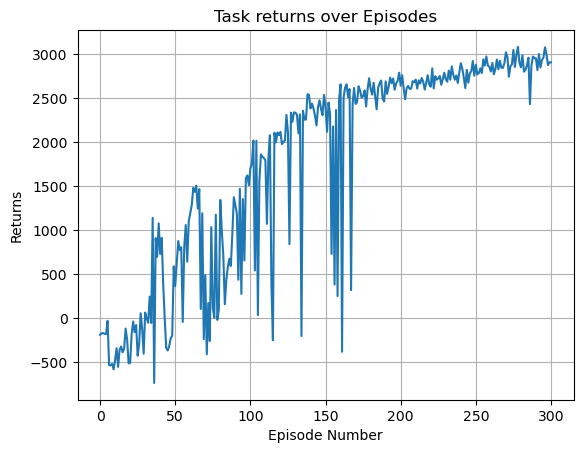

In [52]:
# plot training performance
t.plot(cfg_path=Path().cwd()/'cfg'/'ddpg.yaml',)

In [53]:
# test the trained policy and save a video of the test
t.test(agent, cfg_path=Path().cwd()/'cfg'/'ddpg.yaml', cfg_args=dict(save_video=True,testing=True))

Numpy/Torch/Random Seed:  979
Loading model from /notebooks/rl2023/ex6/results/HalfCheetah-v4/model/HalfCheetah-v4_params.pt ...
Testing ...
Moviepy - Building video /notebooks/rl2023/ex6/results/HalfCheetah-v4/video/test/ex6-episode-0.mp4.
Moviepy - Writing video /notebooks/rl2023/ex6/results/HalfCheetah-v4/video/test/ex6-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /notebooks/rl2023/ex6/results/HalfCheetah-v4/video/test/ex6-episode-0.mp4
Ep0: Test ep_reward is 2961.1059065480486
Ep1: Test ep_reward is 2673.040453006988
Ep2: Test ep_reward is 2949.5075826498146
Ep3: Test ep_reward is 2966.7503517912614
Ep4: Test ep_reward is 2940.927387823205
Ep5: Test ep_reward is 2913.374232286429
Ep6: Test ep_reward is 3079.8490112718287
Ep7: Test ep_reward is 2994.8785255282046
Ep8: Test ep_reward is 2830.492531739292
Moviepy - Building video /notebooks/rl2023/ex6/results/HalfCheetah-v4/video/test/ex6-episode-9.mp4.
Moviepy - Writing video /notebooks/rl2023/ex6/results/HalfCheetah-v4/video/test/ex6-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /notebooks/rl2023/ex6/results/HalfCheetah-v4/video/test/ex6-episode-9.mp4
Ep9: Test ep_reward is 3051.797641486258
Average test reward: 2936.1723624131328


In [55]:
Video(Path().cwd()/'results'/'HalfCheetah-v4'/'video'/'test'/'ex6-episode-9.mp4',
      embed=True, html_attributes="loop autoplay") # Set html_attributes="controls" for video control

<a id='Q1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 1.1</b> On-policy vs off-policy part 1 (10 points) </h3> 

For policy gradient methods seen in Exercise 5, we update the agent using only on-policy data, while in DDPG we can use off-policy data. Why? (Try to answer in 5 sentences)

🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>

Due to the need of culculating policy grdients from expected return of a specific policy, PG methods in Ex5 is inherently on-line. In DDPG, however, policy gradient in culculated by value function, for which we can use experience replay to achieve off-line learning. 

<a id='Q2'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 1.2</b> On-policy vs off-policy part 2 (10 points) </h3> 

A big advantage of DDPG, compared to policy gradient, is that it’s able to utilise off-policy data. What are the disadvantages of deterministic policy gradient compared to the policy gradient method implemented in ex6_PG_AC.ipynb? List two of them.

🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>

1. Due to the fact that DDPG uses deterministic policies, it's more prone to overfitting than PGAC which uses stochastic policies.
2. DDPG obviously can not deal with continuous action space.

# 3. Submitting <a id='3.'></a>
Ensure all tasks and questions (in ```ex6_DDPG.ipynb``` and ```ex6_PG_AC.ipynb```) are answered and the necessary plots are saved in the appropriate locations. The relevant plots and files that need to be submitted for this assignment are:


- Training performance plots:
  - `ddpg.png`: Training performance plots in terms of episode and episodic reward for DDPG
<br>

  
- Model files:
  - `ddpg_params.pt`: Trained model


Ensure the model files and plots are saved in correct paths:
- ```results/HalfCheetah-v4/ddpg.png``` Training result
- ```results/HalfCheetah-v4/model/ddpg_params.pt``` Training Model


<span style="color:red"> **# IMPORTANT: DO NOT FORGET ANOTHER TASK IN ```ex6_PG_AC.ipynb```** </span>

## 3.1 Feedback <a id='3.1'></a>

In order to help the staff of the course as well as the forthcoming students, it would be great if you could answer the following questions in your submission:

1) How much time did you spend solving this exercise? (change the ```hrs``` variable below to a floating point number representing the number of hours taken e.g. 5.43)

In [ ]:
hrs = None

2) Difficulty of each task/question from 1-5 (int or float)

In [ ]:
T1 = None   # Implementing DDPG (20 points)
Q1 = None   # Question 1.1 Reasons of using off-policy data (10 points)
Q2 = None   # Question 1.2 Disadvantages of DDPG (10 points)

3) How well did you understand the content of the task/question from 1-5? (int or float)

In [ ]:
T1 = None   # Implementing DDPG (20 points)
Q1 = None   # Question 1.1 Reasons of using off-policy data (10 points)
Q2 = None   # Question 1.2 Disadvantages of DDPG (10 points)

4) General feedback. Consider questions like:

    - Did the content of the lecture relate well with the assignment?
    - To what extent did you find the material to be potentially useful for your research and studies?
    
Please share any additional feedback, suggestions, or comments you have about the lecture, assignment, or course content. Your input is valuable in helping us improve the learning experience.

DOUBLE CLICK HERE TO EDIT, CLEAR THIS TEXT AND ANSWER HERE

# References <a id='3.'></a>
Please use the following section to record references.

[1] Timothy P. Lillicrap et al. "Continuous control with deep reinforcement learning" ICLR 2016 https://arxiv.org/abs/1509.02971